In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [2]:
plt.style.use('seaborn') # seaborn 스타일로 변환
sns.set(rc={'figure.figsize' : (15,7)})
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings('ignore')

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 0. 대회 설명

  - 대회 : https://www.kaggle.com/c/nyc-taxi-trip-duration/overview
  - 주제 : predicts the total ride duration of taxi trips in New York City
  - 문제 정의 : 특징에 따른 뉴욕 택시 이동 시간은 어떻게 달라질 것인가

# 1. 데이터 불러오기

In [3]:
!kaggle competitions download -c nyc-taxi-trip-duration -p ../../W02

 99%|█████████████████████████████████████▋| 85.0M/85.8M [00:15<00:00, 6.83MB/s]
100%|██████████████████████████████████████| 85.8M/85.8M [00:16<00:00, 5.45MB/s]


In [4]:
import zipfile
zip = zipfile.ZipFile(os.path.join('..', '..', 'W02', 'nyc-taxi-trip-duration.zip'))
zip.extractall(path = '../../W02')

In [7]:
train = pd.read_csv(os.path.join('..', '..', 'W02', 'train.zip'))
test = pd.read_csv(os.path.join('..', '..', 'W02', 'test.zip'))

In [8]:
train.shape, test.shape

((1458644, 11), (625134, 9))

In [9]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

# 2. EDA

## 1-1. 데이터 불러오기('pickup_datetime' 컬럼을 datetime으로 parsing)

## 1-2. 데이터셋의 정보 및 결측치 확인

In [10]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1           -73.982           40.768            -73.965   
1                1           -73.980           40.739            -73.999   
2                1           -73.979           40.764            -74.005   
3                1           -74.010           40.720            -74.012   
4                1           -73.973           40.793            -73.973   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0            40.766                  N            455  
1            40.731                  N            663  
2            40.710                  N           2124  
3            40.707                  N            429  
4            40.783                  N            435

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [12]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## 1-3. 종속변수 산점도 및 히스토그램 그려보기

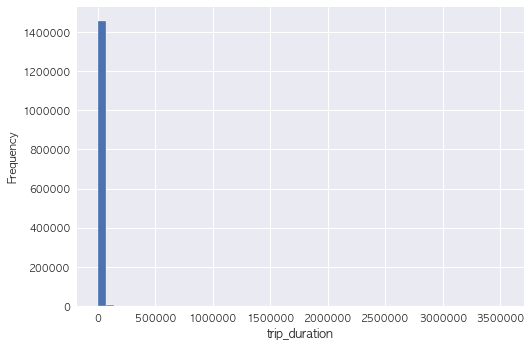

In [13]:
# 한 쪽으로 매우 치우쳐 있음
train['trip_duration'].plot.hist(bins = 50)
plt.xlabel('trip_duration', fontsize = 12)
plt.show()

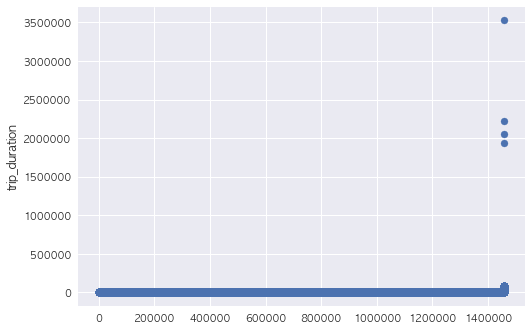

In [14]:
plt.scatter(range(train.shape[0]), np.sort(train.trip_duration.values))
plt.ylabel('trip_duration', fontsize = 12)
plt.show()

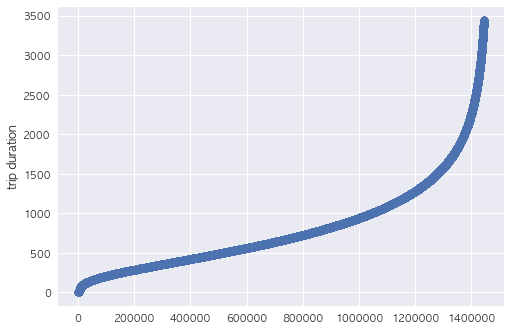

In [15]:
# 99%까지의 trip_duration을 가지고 그린 scatter
# trip_duration의 이상치 판단은 거리 비교를 통해 할 예정
temp = train[train['trip_duration'] < train.trip_duration.quantile(0.99)]
plt.scatter(range(temp.shape[0]), np.sort(temp.trip_duration.values))
plt.ylabel('trip duration', fontsize=12)
plt.show()

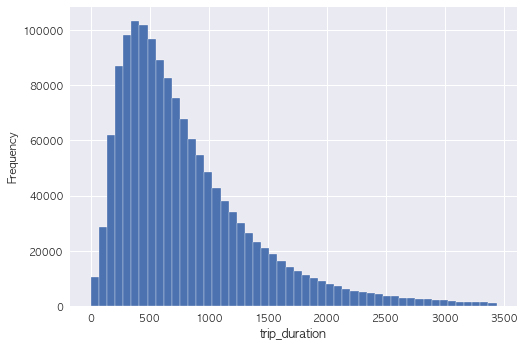

In [16]:
temp['trip_duration'].plot.hist(bins = 50)
plt.xlabel('trip_duration', fontsize = 12)
plt.show()

## 1-4. 종속변수 로그 변환 후 히스토그램

In [17]:
train['log_trip_duration'] = train['trip_duration'].apply(lambda x : np.log(x + 1))

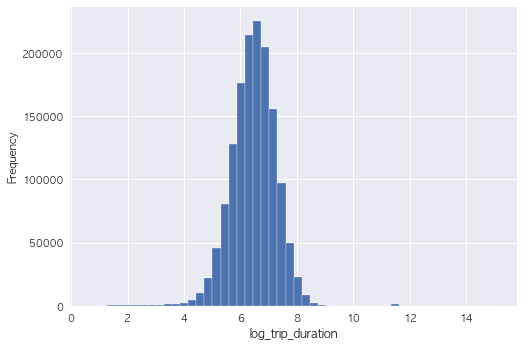

In [18]:
train['log_trip_duration'].plot.hist(bins = 50)
plt.xlabel('log_trip_duration', fontsize = 12)
plt.show()

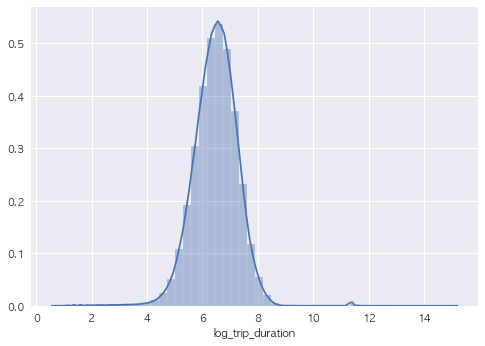

In [19]:
sns.distplot(train["log_trip_duration"], bins =50)
plt.show()

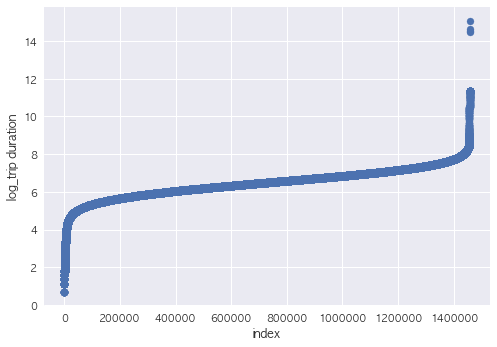

In [20]:
plt.scatter(range(train.shape[0]), np.sort(train.log_trip_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('log_trip duration', fontsize=12)
plt.show()

## 1-5. 날짜 변환

In [21]:
import time
from datetime import datetime

In [22]:
# datetime 형식으로 바꿔주기
train['pickup_datetime'] = train['pickup_datetime'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train['dropoff_datetime'] = train['dropoff_datetime'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test['pickup_datetime'] = test['pickup_datetime'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [23]:
# 택시 탄 시점의 시간을 모두 구분 (초 제외)
def changeDate(df):
    df['pickup_month'] = df['pickup_datetime'].dt.month # 월
    df['pickup_day'] = df['pickup_datetime'].dt.day # 일자
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday # 요일
    df['pickup_hour'] = df['pickup_datetime'].dt.hour # 시간
    df['pickup_minute'] = df['pickup_datetime'].dt.minute # 분
#     df['pickup_second'] = df['pickup_datetime'].dt.second # 초
    return df

In [24]:
train = changeDate(train)
test = changeDate(test)

In [25]:
# 시간별 택시 탑승

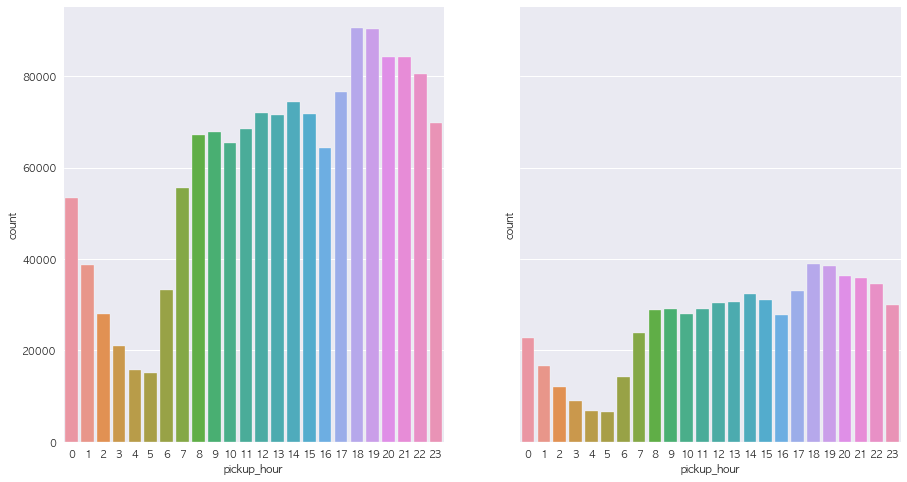

In [26]:
f, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
sns.countplot(train['pickup_hour'], ax = axes[0])
sns.countplot(test['pickup_hour'], ax = axes[1])
plt.show()

In [27]:
# 일자별 택시 탑승 인원 plot

In [28]:
train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date

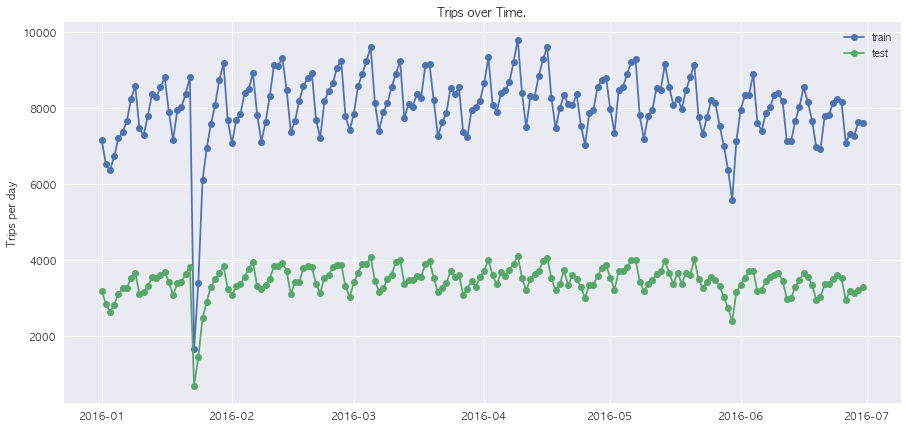

In [29]:
plt.figure(figsize = (15, 7))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips per day')
plt.show()

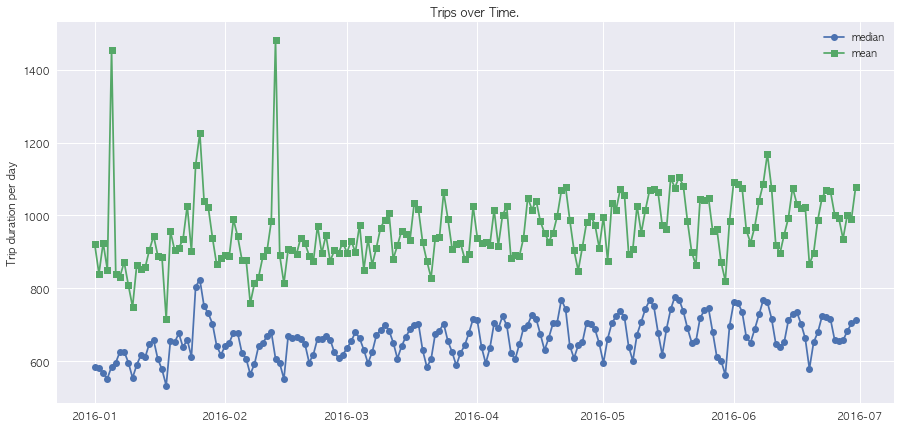

In [30]:
plt.figure(figsize = (15, 7))
plt.plot(train.groupby('pickup_date')[['trip_duration']].median(), 'o-', label='train')
plt.plot(train.groupby('pickup_date')[['trip_duration']].mean(), 's-', label='train')
plt.title('Trips over Time.')
plt.legend(['median', 'mean'])
plt.ylabel('Trip duration per day')
plt.show()

## 1-6.'store_and_fwd_flag' 인코딩

This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server

- Y=store and forward
- N=not a store and forward trip

In [31]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [32]:
# Y는 1로, N은 0으로
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].apply(lambda x : 1 if x == 'Y' else 0)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].apply(lambda x : 1 if x == 'Y' else 0)

# 1-7. passenger_count

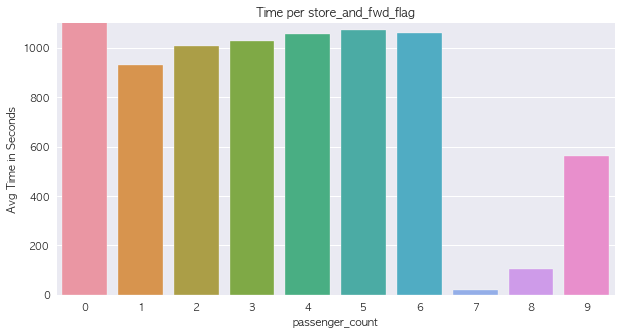

In [33]:
# 승객이 0명인 경우 60개 -> 승객 1명으로 변경
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(10,5))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.ylabel('Avg Time in Seconds')
sns.barplot(pc.index,pc.values)
plt.show()

In [34]:
train.loc[train['passenger_count'] == 0, 'passenger_count'] = 1
test.loc[test['passenger_count'] == 0, 'passenger_count'] = 1

# 2. 데이터 시각화

## 2-1. 'pickup_latitude', 'pickup_longitude'변수 사용하여 geological map그려보기(folium 사용)

In [35]:
import folium

In [36]:
map_osm = folium.Map(location = [40.76793671, -73.98215485], zoom_start = 13)

In [37]:
for lat, lon in train[['pickup_latitude', 'pickup_longitude']].values[:10000]:
    folium.CircleMarker([lat, lon], radius = 1).add_to(map_osm)
    
map_osm

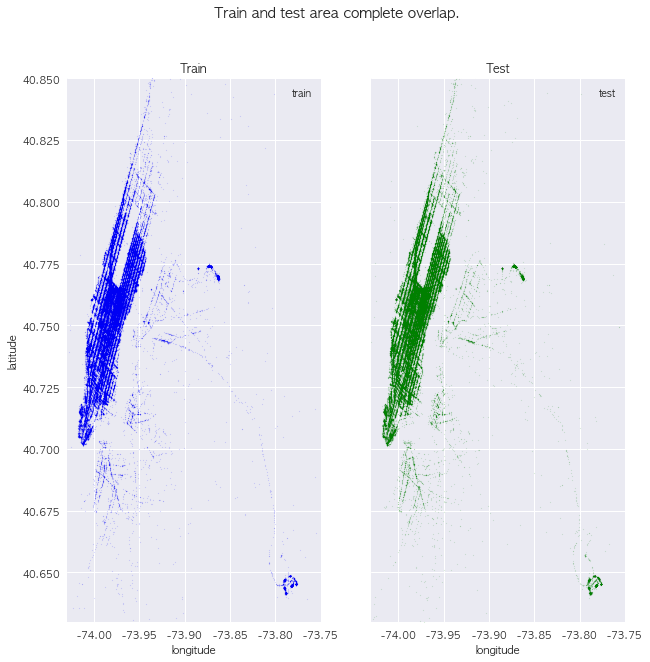

In [38]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize = (10, 10))
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_title('Train')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_title('Test')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [39]:
coord_pickup = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,                  
                          test[['pickup_latitude', 'pickup_longitude']].values))
coord_dropoff = np.vstack((train[['dropoff_latitude', 'dropoff_longitude']].values,                  
                           test[['dropoff_latitude', 'dropoff_longitude']].values))

In [40]:
coords = np.hstack((coord_pickup,coord_dropoff))# 4 dimensional data

In [41]:
from sklearn.cluster import MiniBatchKMeans

In [42]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])
for df in (train, test):
    df.loc[:, 'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude',
                                                         'dropoff_latitude','dropoff_longitude']])

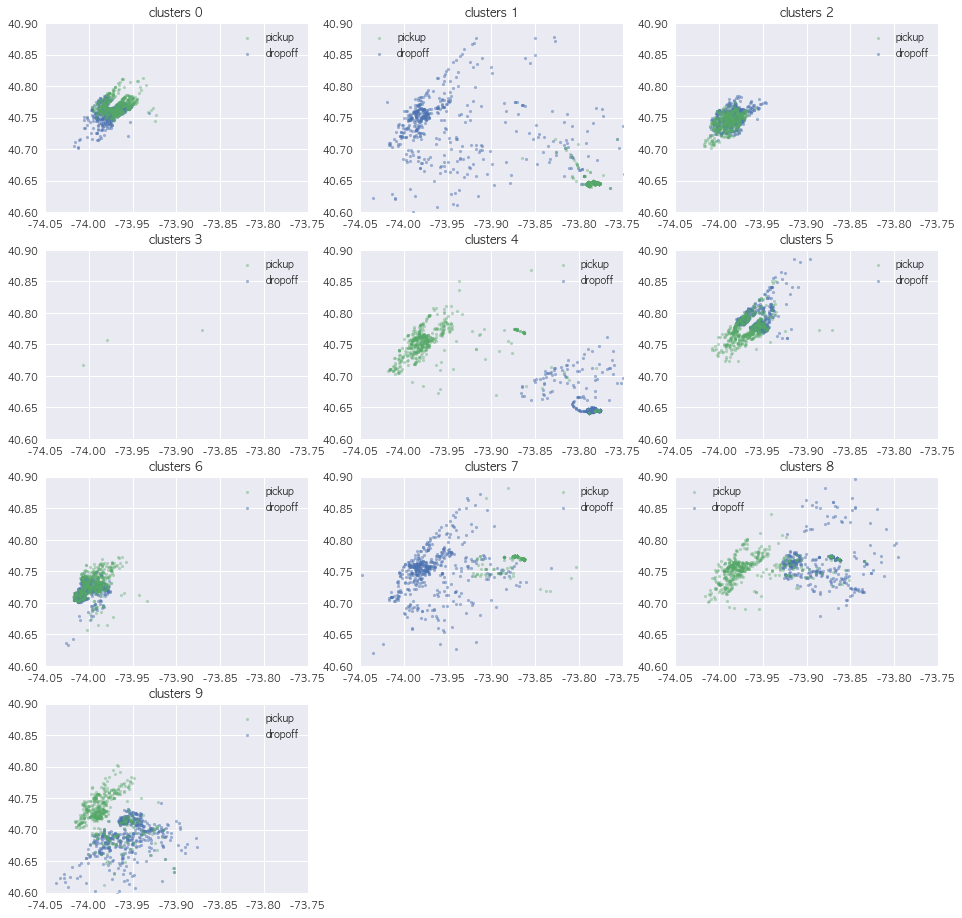

In [43]:
plt.figure(figsize=(16,16))
N = 500
for i in range(10):
    plt.subplot(4,3,i+1)
    tmp_data = train[train.pickup_dropoff_loc==i]
    drop = plt.scatter(tmp_data['dropoff_longitude'][:N], tmp_data['dropoff_latitude'][:N], s=10, lw=0, alpha=0.5,label='dropoff')
    pick = plt.scatter(tmp_data['pickup_longitude'][:N], tmp_data['pickup_latitude'][:N], s=10, lw=0, alpha=0.4,label='pickup')    
    plt.xlim([-74.05,-73.75]);plt.ylim([40.6,40.9])
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)
#plt.axes().set_aspect('equal')

## 2-2. ‘day of week’변수 요일별 빈도수 그래프 그려보기

In [ ]:
train['pickup_weekday'].value_counts().sort_index().plot.bar(rot = 0, figsize = (10, 5))
plt.xticks(range(0,7), ['월', '화', '수', '목', '금', '토', '일'])
plt.ylabel('Freq')
plt.show()

## 2-3. ‘store_and_fwd_flag’변수 density 그래프 그려보기(한 그래프에 그리기)

In [ ]:
sns.distplot(train.loc[train['store_and_fwd_flag'] == 0, 'log_trip_duration'], color = 'blue')
sns.distplot(train.loc[train['store_and_fwd_flag'] == 1, 'log_trip_duration'], color = 'red')

## 2-4. x="dayofweek", y="trip_duration", hue="vendor_id"로 지정하여 boxplot그려보고 해석하기

In [ ]:
plt.figure(figsize = (10, 7))
sns.boxplot(data = train, x = 'pickup_weekday', y = 'log_trip_duration', hue = 'vendor_id')
plt.show()

# 3. 피처엔지니어링

## 3-1. KNYC_Metars.csv파일 불러와서 날씨 변수 추가('Time' 컬럼을 datetime으로 parsing)

In [ ]:
meta = pd.read_csv('KNYC_Metars.csv')

In [ ]:
meta['Time'] = meta['Time'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [ ]:
meta.head()

In [ ]:
### ‘Events’변수의 유일한 값 구하기
meta['Events'].value_counts()

In [ ]:
### 'snow' 변수 만들기
meta['snow'] = meta['Events'].apply(lambda x: 1 if x == 'Fog\n\t,\nSnow' or x == 'Snow' else 0)

In [ ]:
meta = meta.drop('Events', axis = 1)

In [ ]:
### 날짜 변수 만들기
meta['pickup_month'] = meta['Time'].dt.month
meta['pickup_day'] = meta['Time'].dt.day
meta['pickup_hour'] = meta['Time'].dt.hour

In [ ]:
### 2016년도만 불러오기
meta = meta.loc[meta['Time'].dt.year == 2016]

In [ ]:
meta = meta.reset_index(drop = True)

In [ ]:
meta.info()

In [ ]:
# 기후 상태 범주화
meta['Conditions'].value_counts()

In [ ]:
def weather(x):
    if x in ['Overcast', 'Mostly Cloudy', 'Partly Cloudy', 'Scattered Clouds']:
        v = 'cloudy'
    elif x in ['Light Rain', 'Rain', 'Heavy Rain', 'Light Freezing Rain']:
        v = 'rainy'
    elif x in ['Light Snow', 'Snow', 'Heavy Snow']:
        v = 'snowy'
    elif x in ['Light Freezing Fog', 'Haze', 'Fog']:
        v = 'foggy'
    elif x == 'Clear':
        v = 'clear'
    else:
        v = 'unknown'
    return v

In [ ]:
meta['Conditions'] = meta['Conditions'].map(lambda x : weather(x))

In [ ]:
# Null의 비율이 높은 'Windchill' 과 'Heat Index' 제거
(meta.isnull()).sum() / meta.shape[0]

In [ ]:
meta = meta.drop(['Windchill', 'Heat Index'], axis = 1)

In [ ]:
### Visibility 채우기

In [ ]:
temp = meta.groupby(meta['Time'].dt.date)['Visibility'].mean().reset_index()

In [ ]:
temp

In [ ]:
meta['date'] = meta['Time'].dt.date

In [ ]:
visi = []
for dt, v in meta[['date', 'Visibility']].values:
    try:
        int(v)
    except:
        v = temp.loc[temp['Time'] == dt, 'Visibility']
    visi.append(v)

In [ ]:
meta['Visibility'] = visi

In [ ]:
meta = meta[['Humidity', 'Pressure', 'Dew Point', 'Visibility', 'Wind Speed', 'Conditions', 'snow', 'pickup_month', 'pickup_day', 'pickup_hour']]

In [ ]:
meta.isnull().sum()

In [ ]:
train = train.merge(meta, on = ['pickup_month', 'pickup_day', 'pickup_hour'], how = 'left')
test = test.merge(meta, on = ['pickup_month', 'pickup_day', 'pickup_hour'], how = 'left')

In [ ]:
train.shape, test.shape

## 3-2. Haversine distance, Manhattan distance Bearing 거리 계산법을 사용하여 거리 계산

In [ ]:
# 거리 계산 방법
import numbers
import math
from tqdm import tqdm

class GeoUtil:
    """
    Geographical Utils
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

In [ ]:
total = []
for args in tqdm(train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].values):
    x_lon, x_lat = args[:2]
    y_lon, y_lat = args[2:]
    
    dis = GeoUtil.get_harversion_distance(x_lon, x_lat, y_lon, y_lat)
#     dis = GeoUtil.get_harversion_distance(x_lat, x_lon, y_lat, y_lon)
    total.append(dis)

In [ ]:
train['distance'] = total

In [ ]:
total = []
for args in tqdm(test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].values):
    x_lon, x_lat = args[:2]
    y_lon, y_lat = args[2:]
    
    dis = GeoUtil.get_harversion_distance(x_lon, x_lat, y_lon, y_lat)
#     dis = GeoUtil.get_harversion_distance(x_lat, x_lon, y_lat, y_lon)
    total.append(dis)

In [ ]:
test['distance'] = total

In [ ]:
## 3-2. distance가 0인 것 -> 삭제

In [ ]:
train[train['distance'] == 0].shape

In [ ]:
train = train[train['distance'] != 0]

## 3-. 속도 구하기

In [ ]:
train['speed'] = (train['distance'] / (train['trip_duration'] / 3600))

In [ ]:
# 말도안되게 속력이 높거나 낮은 경우
train.loc[(train['speed'] > 150) | (train['speed'] <= 0.5), ['trip_duration', 'distance', 'speed']].sort_values('speed')

In [ ]:
train = train[(train['speed'] <= 150) | (train['speed'] >= 0.5)]

## 3-3. 소수 2번째까지 보이게 하기

In [ ]:
def roundDF(df):
    columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']
    for c in columns:
        df[c] = df[c].apply(lambda x : round(x, 2))
    return df

In [ ]:
train = roundDF(train)
test = roundDF(test)

## 3-4. 'pickup_datetime', 'dropoff_datetime'컬럼 제거하기

In [ ]:
train = train.drop(['pickup_datetime', 'dropoff_datetime', 'pickup_date', 'speed'], axis = 1)
test = test.drop(['pickup_datetime', 'pickup_date'], axis = 1)

## 3-5. feature 생성

In [ ]:
def divideT(x):
    if x >= 0 and x < 7:
        v = '새벽'
    elif x >= 7 and x < 12:
        v = '아침'
    elif x > 12 and x <= 18:
        v = '오후'
    else:
        v = '저녁'
    return v

In [ ]:
# 탑승 시간대 생성
train['pickup_time'] = train['pickup_hour'].map(lambda x : divideT(x))
test['pickup_time'] = test['pickup_hour'].map(lambda x : divideT(x))

In [ ]:
# 탑승 평일/주말 생성

In [ ]:
train['pickup_weekday'].value_counts()

In [ ]:
train['weekend'] = train['pickup_weekday'].apply(lambda x : 0 if x >= 0 and x < 5 else 1)

In [ ]:
test['weekend'] = test['pickup_weekday'].apply(lambda x : 0 if x >= 0 and x < 5 else 1)

## 3-6. 상관관계 확인

In [ ]:
train.shape, test.shape

In [ ]:
columns = list(train.isnull().sum().sort_values().index[1:19])

In [ ]:
columns.remove('log_trip_duration')
columns.remove('trip_duration')

In [ ]:
### 상관관계 확인
plt.figure(figsize = (16,16))
sns.heatmap(train[columns].corr(), annot = True, cmap = 'summer')
plt.show()

# 4. 모델링

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

## 4-0. train, valid split 진행

In [ ]:
train.info()

In [ ]:
train = train.fillna(0)
test = test.fillna(0)

In [ ]:
train = train.drop('pickup_day', axis = 1)
test = test.drop('pickup_day', axis = 1)

In [ ]:
def changeType(df):
    columns = ['vendor_id', 'pickup_month', 'pickup_weekday', 'pickup_time', 'pickup_dropoff_loc']
    for c in columns:
        df[c] = df[c].astype(str)
    df['Visibility'] = df['Visibility'].astype(float)
    return df

In [ ]:
train = changeType(train)
test = changeType(test)

In [ ]:
train = train.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1)
test = test.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1)

In [ ]:
tr_id = train['id']
X = train.drop(['id', 'trip_duration', 'log_trip_duration'], axis = 1)
X = pd.get_dummies(X)
y = train['trip_duration']

In [ ]:
te_id = test['id']
X_t = test.drop('id', axis = 1)
X_t = pd.get_dummies(X_t)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

In [ ]:
X_t.shape

## 4-1. RMSLE 함수 정의하기

In [ ]:
def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score

In [ ]:
from sklearn.metrics.scorer import make_scorer

RMSLE = make_scorer(rmsle_score)

## 4-2. 통계확인

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.OLS(y.values, X)

In [ ]:
re = model.fit()
re.summary()

In [ ]:
import xgboost as xgb

In [ ]:
y_train = y_train.reset_index().drop('index',axis = 1)
y_valid = y_valid.reset_index().drop('index',axis = 1)

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

In [2]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

NameError: name 'dtrain' is not defined

## 4-3. submission test

In [234]:
dtest = xgb.DMatrix(X_t)

In [235]:
pred = model.predict(dtest)

In [237]:
sub = pd.read_csv('sample_submission.csv')

In [238]:
sub['trip_duration'] = pred

In [239]:
sub.to_csv('./submission_6.csv', index = False)